In [1]:
import os
import sys

from omegaconf import OmegaConf
from matplotlib import pyplot as plt
import cv2
from torchvision.transforms import ToPILImage, Grayscale
from torchmetrics import StructuralSimilarityIndexMeasure as SSIM
import torch
to_pil = ToPILImage()
to_gray = Grayscale()
ssim_metric = SSIM(return_full_image=True)

sys.path.append(os.path.abspath(os.path.join('..')))

from src.models.model import Decomposer
from src.data.siar_data import SIAR

/Users/boris/Library/Mobile Documents/com~apple~CloudDocs/Uni/Master/4. Semester/CV_Project/decomposition_learning/venv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/Users/boris/Library/Mobile Documents/com~apple~CloudDocs/Uni/Master/4. Semester/CV_Project/decomposition_learning/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_path = "../config/occ_generation_w_model.yaml" # Contains the path to the model checkpoint and the data

config = OmegaConf.load(config_path)

model = Decomposer.load_from_checkpoint(
    config.model.checkpoint, config=config, log_dir=None, map_location='cpu'
)

dataset = SIAR(split='train', manual_dataset_path=config.data.path_to_data)

/Users/boris/Library/Mobile Documents/com~apple~CloudDocs/Uni/Master/4. Semester/CV_Project/decomposition_learning/venv/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
def get_X_SL(input_sequence, model):
    (oi_reconstruction,
    light_mask,
    shadow_mask,
    _,
    _) = model(input_sequence.unsqueeze(0))
    oi_reconstruction_repeated = oi_reconstruction.unsqueeze(1).repeat(1, 10, 1, 1)
    X_SL = (oi_reconstruction_repeated * shadow_mask) + light_mask
    X_SL = X_SL.swapaxes(0, 1)
    return X_SL

def get_mask_ssim(input_img, x_sl, threshold=0.3):
    ssim = ssim_metric(x_sl, input_img)
    # ssim = ssim_metric(x_sl.unsqueeze(0), input_img.unsqueeze(0))
    ssim_img = ssim[1].squeeze(0)
    #invert ssim_img
    ssim_img = 1 - ssim_img
    # threshold ssim_img
    ssim_img[ssim_img < threshold] = 0
    ssim_img[ssim_img >= threshold] = 1
    return ssim_img

def get_mask_subtraction(input_img, x_sl, threshold=0.3, use_adaptive_thresholding=False):
    extracted_occlusion = torch.abs(input_img - x_sl)
    # extracted_occlusion[extracted_occlusion < threshold] = 0
    # extracted_occlusion[extracted_occlusion >= threshold] = 1

    # adaptive thresholding
    if use_adaptive_thresholding:
        extracted_occlusion = extracted_occlusion.squeeze(0)
        extracted_occlusion = extracted_occlusion.detach().numpy() * 255
        extracted_occlusion = extracted_occlusion.astype('uint8')
        extracted_occlusion = extracted_occlusion.swapaxes(0, 1).swapaxes(1, 2)
        extracted_occlusion = cv2.cvtColor(extracted_occlusion, cv2.COLOR_RGB2GRAY)
        extracted_occlusion = cv2.adaptiveThreshold(extracted_occlusion, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
        extracted_occlusion = cv2.cvtColor(extracted_occlusion, cv2.COLOR_GRAY2RGB)
        extracted_occlusion = extracted_occlusion.swapaxes(1, 2).swapaxes(0, 1)
        extracted_occlusion = extracted_occlusion / 255.0
        extracted_occlusion = torch.from_numpy(extracted_occlusion).float()
    else:
        extracted_occlusion[extracted_occlusion < threshold] = 0
        extracted_occlusion[extracted_occlusion >= threshold] = 1

    return extracted_occlusion

def plot_input_and_masks(input_img, x_sl, ssim_img, subtraction_img):
    fig, axs = plt.subplots(2, 4, figsize=(10, 6))
    # all images in color
    axs[0, 0].imshow(to_pil(input_img))
    axs[0, 0].set_title('Input image')
    axs[0, 1].imshow(to_pil(x_sl))
    axs[0, 1].set_title('X_SL')
    axs[0, 2].imshow(to_pil(ssim_img))
    axs[0, 2].set_title('SSIM mask')
    axs[0, 3].imshow(to_pil(subtraction_img))
    axs[0, 3].set_title('Subtraction mask')

    # all images but in greyscale
    axs[1, 0].imshow(to_gray(to_pil(input_img)), cmap='gray')
    axs[1, 0].set_title('Input image')
    axs[1, 1].imshow(to_gray(to_pil(x_sl)), cmap='gray')
    axs[1, 1].set_title('X_SL')
    axs[1, 2].imshow(to_gray(to_pil(ssim_img)), cmap='gray')
    axs[1, 2].set_title('SSIM mask')
    axs[1, 3].imshow(to_gray(to_pil(subtraction_img)), cmap='gray')
    axs[1, 3].set_title('Subtraction mask')

    plt.show()

In [4]:
# Get all X_SL for one sample sequence of dataset from model
sample = 0

input_images, _, _, _ = dataset[sample]
X_SL = get_X_SL(input_images, model) # X_SL.shape = (10, 3, 256, 256)
input_images = input_images.swapaxes(0,1) # input_images.shape = (10, 3, 256, 256)

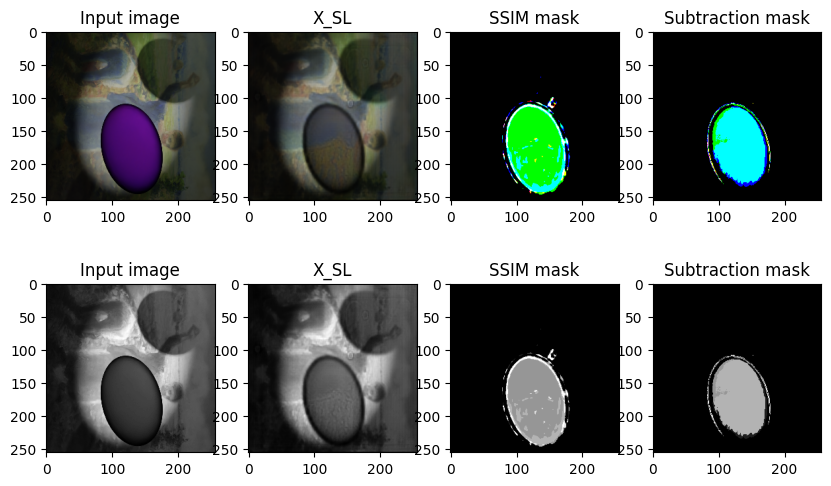

In [8]:
# Plot input image and masks for one input image of sample sequence
example = 0
ssim_threshold = 0.4
subtraction_threshold = 0.15

ssim_img = get_mask_ssim(input_images, X_SL, ssim_threshold)
subtraction_img = get_mask_subtraction(input_images, X_SL, subtraction_threshold)
plot_input_and_masks(input_images[example], X_SL[example], ssim_img[example], subtraction_img[example])

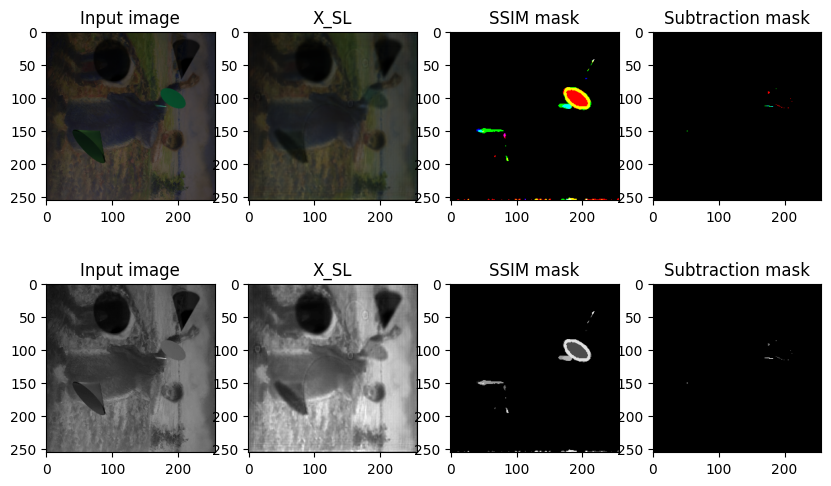

In [19]:
i = 9

plot_input_and_masks(input_images[i], X_SL[i], ssim_img[i], subtraction_img[i])

## SIIM
Sometimes SSIM Masks are better, given a proper threshold.

## Subtraction
Most of the time, subtraction is better, but it is more sensitive to noise and again a proper threshold parameter.